# Setup

In [1]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [2]:
#| export
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import math

# Introduction

Here we want to build the model(s) architecture. 

## Problems 

- Can we not train this model with decision trees? 
    - Transformers make sense as they clearly factor in the input data and the relationships between them. (I also want practice with them).
    - Unsure whether there is enough data to be able to support this model.
    - Ultimately this is a classification problem. Can we not do this with decision trees?
- Which Transformer Architecture?
    - Too complex? Should I be looking into this at all? I am simply trying to implement a transformer model, BERT and GPT use this and have an additive portion onto it. It might not be worth considering.
    - BERT raises interest because of its bidirectional attention. However is this needed? Our problem can be framed as such, as all we want in the end is a model that can predict a good next ingredient, given the ingredients that are already there.
        - The only thing worth considering here is using it for assigning quantities. Depending on how this is done, it would be useful to be able to know all of the ingredients before assigning quantities to them. 
            - Worth considering here is whether there is a much simpler model that could be used to assign quantities from token embeddings?
    - Research:
        - [What Language Model Architecture and Pretraining Objective Work Best for Zero-Shot Generalization?
        ](https://arxiv.org/abs/2204.05832)
            - Reddit: TLDR: Decoder only works better if all you're doing is unsupervised pre-training and hoping it generalizes, but encoder decoder works better if you can do multi-task fine tuning, and it's not TOO hard to convert models between the two architectures. Worth noting that this paper predates RLHF, so it's probably the case that decoder only + RLHF (e.g. Chat-GPT) outperforms encoder-decoder + multi-task fine tuning (e.g. Flan-T5).
        - [Decoder-Only or Encoder-Decoder? Interpreting Language Model as a Regularized Encoder-Decoder](https://arxiv.org/abs/2304.04052)
        - Reddit: The reason you'd use encoder-decoder models over decoder-only models is if you expect the inputs to differ in nature wrt the outputs somehow. What T5 had was a "task/query encoder", whereas the decoder was the actual generative model. T5 was a step in blurring the line between NLP tasks and pure language modeling. You can see decoder-only LLMs as the definitive way of breaking this distinction.
- Predicting Foods and Quantities
    - This could be approached either by finding a way of modelling both simultaneously (seems possible), or for simplicity (as I am just starting out), splitting both tasks to separate models.
        - As I am just starting out and developing my understanding of transformers I will split the problem up, firslty by starting to generate foods only.
        - Intuitively, it makes sense if there was one model that could produce both foods and quantities. The choice of the next food does depend on the quantity of foods already present. 
        - It does seem possible to add the quantity to the model, mathematically it is simply just a multiplier. However I'd need a deeper understanding of how predictions are made, and understood by the model.
- Penalising Duplicates: no matter which type of architecture is chosen, there is still the problem that keeps coming up of the model predicting tokens which are already in the series.
    - Loss function penalty: modifying the cross entropy loss to add a penalty for duplicate terms.
    - Emergent property: if all duplicates from recipes were removed, could the model learn this itself?
        - This should be tested roughly. But this might be something that emerges much later on in training, and possibly with much larger models.
    - Other penalty methods: Not sure if there are other ways of doing so without involving the loss - though not actually required.
    - [Aligned Cross Entropy for Non-Autoregressive Machine Translation](https://proceedings.mlr.press/v119/ghazvininejad20a/ghazvininejad20a.pdf)
- Loss Function
    - The autoregressive approach looks to be the best one here. When doing this we should modify our loss function so that our results should be position independant. The way this could be done is evaluating all labels simultaneously in one line, which effectively changes it from multiple multi-class classification problems (for each token prediction) into a single multi-label classification problem. The outputs here should contain one single combined logits vector, from which the top `n_predictions` tokens would be selected.

### Notes 

- Guide calls feed forward networks PositionWiseFeedForward - is there anything special that makes them positional, or is this name for guidance?

### Approach

What should the approach be here. It's a good idea to start simple all the way to the end, and build my way up incrementally. However how simple do we want / can we go? 

It makes sense to use a transformer, as the attention mechanism is what will be driving the predictions here. If we started with something even more simple, ie. a linear layer, we would need a way of feeding in the input data, in order to form predictions for the output ie. the masked tokens. This method of feeding in the input data would be something very crude, like adding the token vectors together. It just wouldn't work.

Let's use a transformer. It could be simple if thought of as a black-box, where all my focus would be just getting it to run. The other option is to write my own version of a transformer (with references), with an attempt to make it as simple as possible. ie. single layer feed-forward networks, single head of attention, no other masking, no misc techiniques such as dropout etc.

# Model Choice

Transformers are chosen here for their attention mechanism. The information required in a recipe generator here are the tokens that are already present - precisely what the attention mechanism serves.

It fits our problem exactly. We need a model that is able to take into the account the relationship between the tokens in the recipe (that is the only data that it is given), and is exacly what the attention mechanism does. It is able to learn relationships between tokens and with this predict what tokens would be best to output. 

This learnable network mechanism allows the model to learn not only pairwise relationships but higher order ones too to encode the set.

For the past week I've been implementing various models, and through that understanding a lot more about them and their varying types. It's nice to have my knowledge cleared up about them - I've found an article that frames the problem that I've been having perfectly (autoregression vs autoencoders). This is the type of thing that I feel silly not knowing, but I need to keep in mind that in retrospect I really didn't have a clear sight of the exact problem, and that I needed to explore to find it.

## Autoregressive or Not

https://huggingface.co/transformers/v3.1.0/model_summary.html - An excellently simple summary of all the questions I've been having. "Note that the only difference between autoregressive models and autoencoding models is in the way the model is pretrained. Therefore, the same architecture can be used for both autoregressive and autoencoding models. When a given model has been used for both types of pretraining, we have put it in the category corresponding to the article where it was first introduced."

### Intuitions

Intuitive: When it comes to pretraining, a self-supervised masking makes more sense intuitively. It will be able to be trained accurately when masking, and following this it can be trained again to be used for text generation.

Faster: Non-autoregressive machine translation models can signif- icantly improve decoding speed by predicting every word in parallel (Gu et al., 2018; Libovicky ́ & Helcl, 2018). This advantage comes at a cost to performance since modeling word order is trickier when the model cannot condition on its previous predictions. https://arxiv.org/abs/1905.11006

### Assumptions 

- Autoregressive model training would involve a high rate of error by asking it to predict all tokens from only one previous context.
    - This would cause the model to generalise more? It will try very hard to compensate and minimise this error, choosing very highly probable ingredients (eg. cheese).
    - Counterargument: We could pretrain it in stages, with more context in the first stage, and decreasing the minimum context later on.

### Research

- Counteragument: "It has been argued that the pre-training objective used by BERT is not well suited for tasks that require decoding texts, e.g., conditional text generation in machine translation and summarization ([Yang et al., 2019](https://arxiv.org/abs/1906.08237))" #TODO: see details
- "Non-autoregressive machine translation models significantly speed up decoding by allowing for parallel prediction of the entire target sequence. However, modeling word order is more challenging due to the lack of autoregressive factors in the model. https://proceedings.mlr.press/v119/ghazvininejad20a/ghazvininejad20a.pdf 
    - We don't require ordering which according to this is the main challenge. This might be a reason that this would work for our case?

### Decision

For our task, it does seem like autoregressive models would be best. They are more accurate, as they can evaluate each one token at a time. The cons of this is that they are slower to train (work sequentially rather than in parallel) - which we are not so concerned about as we have a small dataset with small sequences.

## Encoder vs Decoder

Maybe that article isn't entirely what's worth considering. We can also formulate our problem as Encoder vs Decoder vs Encoder-Decoder architectures.

## Loss Function

Overlooked slightly, the loss function here will be important. We don't care for positions, so the loss function here needs to also be fluid in this. It should have a way of comparing the whole context with the whole labels. 

### Research

Through a conversation with chatGPT, I've found a number of options, all of which might interlink with eachother.

- Set Transformer: Position invariant architecture
- Max/Sum Pooling: This is pretty much what I've been doing with the loss function
- Permutation Invariant Loss: N! complexity
- Shuffling data: Keeping everything the same but training the model with shuffled order of tokens (in each epoch?) to make it robust to order. This is Data Augmentation - it would be better if we came up with a architectural method ƒor the model to solve this problem, rather than relying on the possibility for it to learn this through Data Augmentation.

#### Set Transformer

https://arxiv.org/abs/1703.06114
https://arxiv.org/abs/1810.00825

This should have some value here, but how much so I'm not sure. We could be able to take just a part of it if needed. Regardless I'll learn a lot about "position invariant" ML problems.

##### Pooling

Here the decoder part of the architecture involves a sum pooling, which actually defines a position invariant model.

##### Attention Heads

What I know about attention is that it is already position invariant (hence the need for positional embeddings). However I am not certain, and the paper could highlight somehting I'm not correct in.

Reducing attention's $O(n^2)$ complexity to $O(n)$ - is this a vital part of the architecture, or can it be separated out? We don't need this component, dot product wokrs well and is effective. This is only for problems where $n >> 1$. It is mentioned at the end that the set operations are permutation equivariant - but doesn't mention how. Appendix? I'm not sure if anything is done here - what I already know about attention is that it is position invariant - I could be wrong.

## Questions

How are token probabilites (logits) created from a list of tokens? 

This seems to be really simple, it's done by a linear model which takes n_tokens as inputs, and generates a n_tokens x n_vocab probability vector.

## Problems 

# Data Preparation

Here each batch will have `batch_size` recipes. Each of these recipes will be fed into the model as:
- x: food_ids with 15% of their foods masked with a `[MASK]` token. 
- y: food_ids without mask

This will result in a matrix of size `batch_size` x `recipe_size` x `n_features`.

Problems:

- Create numerous mask elements of each recipe.
    - Will this cause overfit (data leakage -> feeding the model the answer)?
    - Overfitting on large recipes (more possible mask combinations)?
- Decision on where to get vectors.
    - It's much easier to work with a dataset of tokens rather - so possibly in the model itself?

Now we want to create a dataset of recipes with masked ingredients. How can we do this without creating duplicates?

# Training

Here we want to get a model to run on our data. We will just use a black-box pytorch Transformer (which output the same dimension vector as the inputs?).

There are a number of reasons we aren't expecting quality predictions:

- Data
    - Small dataset sample
    - Not scaled
- Model
    - Parameter initialisation (might be built in)
    - Incorrect loss function (should evalute only masks - transformer is not predicing it is transforming here)
    - Architecture optimisations - probably unnecessary.

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 2
n_epochs = 5000
learning_rate = 1e-3

In [4]:
food_vectors = torch.tensor(np.load('../../data/local/final/food_compounds/0.npy'), dtype=torch.float).to(device)
food_vectors, food_vectors.shape

(tensor([[0.0000, 0.0000, 0.1093,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1093,  ..., 0.0000, 0.0000, 1.2232],
         [0.0000, 0.0000, 0.1093,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0'),
 torch.Size([1108, 713]))

In [5]:
data_ratios = [0.8, 0.2]

data = np.load('../../data/local/final/recipe_food_ids/0.npy')

np.random.shuffle(data)

data_train = data[:int(data_ratios[0]*len(data))]
data_validation = data[int(data_ratios[0]*len(data)):]

data.shape, data_train.shape, data_validation.shape

((302, 15), (241, 15), (61, 15))

In [6]:
train_dl = DataLoader(MaskedRecipeDataset(data), batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(MaskedRecipeDataset(data), batch_size=batch_size, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape

torch.Size([2, 15])

In [19]:
model = nn.Transformer(
    d_model=food_vectors.shape[1], 
    nhead=1,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=800,
    dropout=0,
    batch_first=True
)

model.to(device)

loss_func = nn.CrossEntropyLoss() #TODO: make custom to only measure masked loss

optimizer = AdamW(model.parameters(), lr=learning_rate)

In [20]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

8.403592 M parameters


In [42]:
training_metrics = []

for epoch in range(n_epochs):

    # get sample of data
    xb, yb = next(iter(train_dl))
    xb = torch.stack([food_vectors[b] for b in xb]).to(device)
    yb = torch.stack([food_vectors[b] for b in yb]).to(device)

    # evaluate loss 
    output = model(xb,yb)
    train_loss = loss_func(output, yb)
    optimizer.zero_grad(set_to_none=True)
    train_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:

        xb_validation, yb_validation = next(iter(validation_dl))
        xb_validation = torch.stack([food_vectors[b] for b in xb_validation])
        yb_validation = torch.stack([food_vectors[b] for b in yb_validation])

        with torch.no_grad():
            output = model(xb_validation, yb_validation)
            validation_loss = loss_func(output, yb_validation)

        training_metrics.append({
            'epoch': epoch, 'train_loss': train_loss.to('cpu'), 'validation_loss': validation_loss.to('cpu'), 'validation_output': output, 'validation_target': yb_validation
        })

In [31]:
training_metrics[100]['validation_output'][0]

tensor([[ 0.3616, -0.0326,  1.7352,  ..., -0.2227,  0.2965,  1.3963],
        [ 0.6556,  0.1868, -0.5410,  ..., -0.0951,  0.1144, -0.0409],
        [ 0.2447, -0.1630,  2.5954,  ..., -0.2422,  0.3562,  2.0182],
        ...,
        [ 0.1364,  0.1424, -1.5657,  ...,  0.1731, -0.2873, -0.8852],
        [ 0.1364,  0.1424, -1.5657,  ...,  0.1731, -0.2873, -0.8852],
        [ 0.1364,  0.1424, -1.5657,  ...,  0.1731, -0.2873, -0.8852]],
       device='cuda:0')

In [41]:
from scipy import spatial

tree = spatial.KDTree(food_vectors.to('cpu'))

output = training_metrics[100]['validation_output'][0].to('cpu')

for food in output:
    print(tree.query(food))

(52.035335420633324, 1107)
(53.093309950026395, 637)
(46.967519409145034, 1107)
(52.05657858237572, 1107)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)
(44.23627402110186, 1106)


In [43]:
output = training_metrics[100]['validation_target'][0].to('cpu')

for food in output:
    print(tree.query(food))

(0.0, 269)
(0.0, 631)
(0.0, 460)
(0.0, 13)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)
(0.0, 1106)


That's not good. We are transforming the tokens mostly to masked tokens.

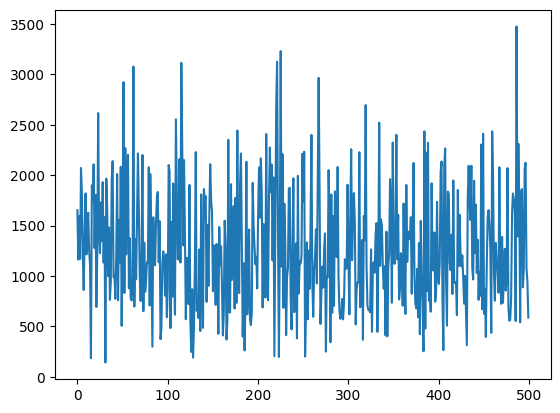

In [44]:
import matplotlib.pyplot as plt

plt.plot([m['train_loss'].detach().numpy() for m in training_metrics])

# Creating Own Model

Questions to ask before:

We are looking for predictions of only the masked tokens, as a set of probabilities (logits) for every possible token. ie. `[batch_size, n_masks, n_tokens]`. How do the models achieve this? If understood I could implement this into the PyTorch easily.

- https://github.com/dhlee347/pytorchic-bert/tree/master
- https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py#L41
    - requires reshifting of data generation (which is easily possible) but not sure if it will help improve results.

Questions when looking through BERT to try to figure it out. 

Where is the masking done? Is it done in the data loading stage, or is it done in the model itself?